# Loading Model from Weights for Evaluation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))

In [3]:
import tensorflow as tf

input = tf.keras.layers.Input((200,6))
x = tf.keras.layers.LSTM(512, return_sequences=True)(input)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
x = tf.keras.layers.LSTM(128)(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

embedding_network = tf.keras.Model(input, x)

input_1 = tf.keras.layers.Input((200,6))
input_2 = tf.keras.layers.Input((200,6))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(tower_1 - tower_2), axis=1, keepdims=True), tf.keras.backend.epsilon()))

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(merge_layer)

keras_siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [4]:
keras_siamese.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy"])
keras_siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 6)]             0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 200, 6)]             0         []                            
                                                                                                  
 model (Functional)          (None, 64)                   2072256   ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 64)                   0         ['model[0][0]',         

Loading Test data from saved NumPy files

In [5]:
import numpy as np
import os

# Load test data from Google Drive
test_data_path = '/content/drive/MyDrive/Implementation/dataset_preprocessed'

# Load test data from the specified path
test_X_1 = np.load(os.path.join(test_data_path, 'X_test_1.npy'))
test_X_2 = np.load(os.path.join(test_data_path, 'X_test_2.npy'))
test_y = np.load(os.path.join(test_data_path, 'test_labels.npy'))

In [6]:
print(test_y.size)

816


In [7]:
# Update the path as needed
checkpoint_dir = '/content/drive/MyDrive/Implementation/Model_BinaryLoss_Euclid/training_checkpoints'

latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

keras_siamese.load_weights(latest_checkpoint)

# Performing basic Model.Evaluate

In [8]:
# Evaluate the model
evaluation = keras_siamese.evaluate([test_X_1, test_X_2], test_y)

# Print evaluation results
print("Loss:", evaluation[0])
print("Accuracy of Non-Converted Non-Quantized Model:", evaluation[1])

26/26 [==============================] - 52s 2s/step - loss: 0.6982 - accuracy: 0.4583
Loss: 0.6981887221336365
Accuracy of Non-Converted Non-Quantized Model: 0.4583333432674408


# Calculating Equal Error Rate (EER)

Calculate Equal Error Rate using a sweeping threshold

In [9]:
# Creating an array of all predictions with Test set for eval
predictions_raw = keras_siamese.predict([test_X_1, test_X_2])

26/26 [==============================] - 48s 2s/step


EER Calculation was based on:
https://github.com/YuanGongND/python-compute-eer?tab=readme-ov-file

In [10]:
import numpy as np

scores = predictions_raw  # Scores between 0 and 1

labels = test_y

# Threshold sweep
sweep_thresholds = np.linspace(0, 1, 100)
far = np.zeros_like(sweep_thresholds)
frr = np.zeros_like(sweep_thresholds)

for i, threshold in enumerate(sweep_thresholds):
  # Make predictions based on threshold
  eer_predictions = scores > threshold

  # Calculate FAR and FRR
  far[i] = np.mean(eer_predictions[labels == 0])  # False Acceptance Rate
  frr[i] = np.mean(1 - eer_predictions[labels == 1])  # False Rejection Rate

# Find the EER (equal error rate)
eer_threshold = sweep_thresholds[np.argmin(np.abs(far - frr))]
eer = np.min(np.abs(far - frr))

print(f"Equal Error Rate (EER): {eer:.4f} at threshold: {eer_threshold:.4f}")

Equal Error Rate (EER): 0.7268 at threshold: 0.4848


In [22]:
far_at_threshold = far[np.where(sweep_thresholds == eer_threshold)[0][0]]
frr_at_threshold = frr[np.where(sweep_thresholds == eer_threshold)[0][0]]

print(f"False Rejection Rate at Threshold: {frr_at_threshold:.4f}")
print(f"False Acceptance Rate at Threshold: {far_at_threshold:.4f}")

False Rejection Rate at Threshold: 0.9257
False Acceptance Rate at Threshold: 0.1989


# Plotting Confusion Matrix (Based on EER)

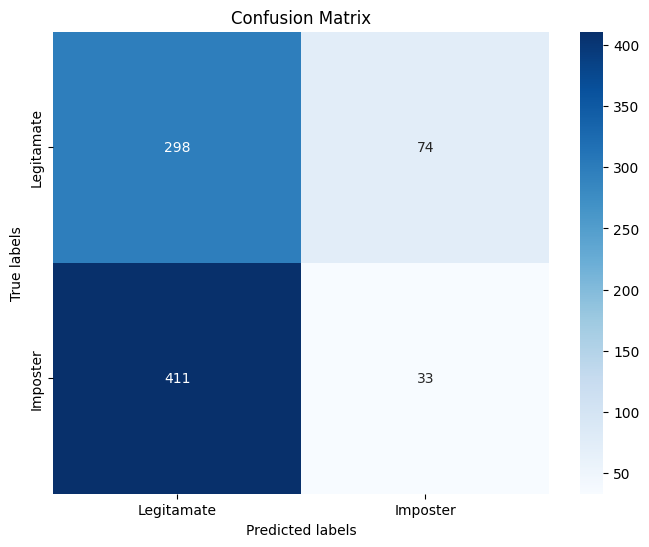

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_labels = ['Legitamate', 'Imposter']

predictions = (predictions_raw > eer_threshold).astype(int)
cm = confusion_matrix(test_y, predictions)

# Plot confusion matrix with sample counts
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plotting ROC CURVE

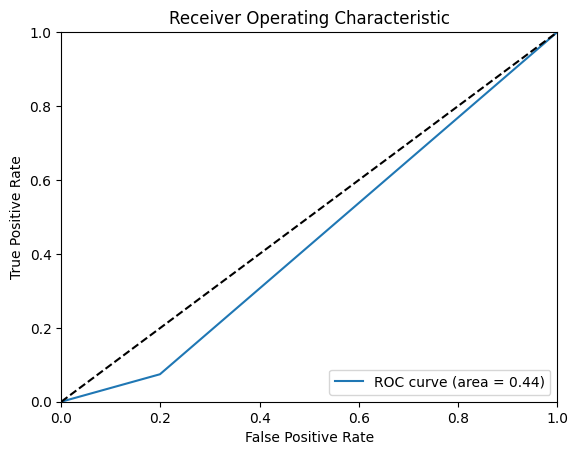

In [15]:
# Plot AUC and ROC curve
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [16]:
print(f"False Positive Rate {fpr[1]:.4f}")
print(f"True Positive Rate {tpr[1]:.4f}")

False Positive Rate 0.1989
True Positive Rate 0.0743


# Converting to TFLite (No quantization)

In [17]:
# Convert the Keras model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(keras_siamese)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
tflite_model_path = '/content/drive/MyDrive/Implementation/Model_BinaryLoss_Euclid/siamese_binaryLoss_euclid_.tflite'
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)
  print("The model was successfully converted to Tensorflow Lite!")

The model was successfully converted to Tensorflow Lite!


# Converting to TFLite (With quantization)

In [18]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()
quantized_tflite_path = '/content/drive/MyDrive/Implementation/Model_BinaryLoss_Euclid/siamese_binaryLoss_euclid_quantized.tflite'
with open(quantized_tflite_path, 'wb') as f:
  f.write(quantized_tflite_model)
  print("The model was successfully converted to Quantized Tensorflow Lite!")

The model was successfully converted to Quantized Tensorflow Lite!


# Using TFLite Python runtime for inferencing and evaluation

In [19]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_path))
interpreter.allocate_tensors()

In [20]:
import numpy as np
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on the first example from the test set
test_sample_1 = test_X_1[1]
test_sample_2 = test_X_2[1]

# Preprocess the input data as needed.
input_data_1 = np.expand_dims(test_sample_1, axis=0).astype(np.float32)
input_data_2 = np.expand_dims(test_sample_2, axis=0).astype(np.float32)

# Set input tensors.
interpreter.set_tensor(input_details[0]['index'], input_data_1)
interpreter.set_tensor(input_details[1]['index'], input_data_2)

# Run the inference.
interpreter.invoke()

# Get the output.
output_data = interpreter.get_tensor(output_details[0]['index'])

# Print the prediction.
print("Prediction:", output_data)


Prediction: [[0.48170406]]


In [21]:
# Get the corresponding label for the test sample
true_label = test_y[1]
print("Label", true_label)

# Compare the prediction with the true label
# Using Threshold extracted from EER
if output_data > eer_threshold and true_label == 1:
  print("Correct prediction: Legitimate transaction")
elif output_data <= eer_threshold and true_label == 0:
  print("Correct prediction: Imposter transaction")
else:
  print("Incorrect prediction")


Label 0.0
Correct prediction: Imposter transaction


# Testing the accuracy when inferencing the Non-Quantized Model

In [22]:
import copy

def evaluate_model(interpreter):
  # Get input details
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()[0]['index']

  # Evaluate the model
  predictions=[]
  for i in range(len(test_X_1)):
    # Set input tensors
    input_data_1 = np.expand_dims(test_X_1[i], axis=0).astype(np.float32)
    input_data_2 = np.expand_dims(test_X_2[i], axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], input_data_1)
    interpreter.set_tensor(input_details[1]['index'], input_data_2)

    # Run inference
    interpreter.invoke()

    # Get output tensor
    output_data = interpreter.tensor(output_details)
    predictions.append(copy.copy(output_data()[0]))

  return predictions

In [23]:
predictions = evaluate_model(interpreter)

In [29]:
accurate_count = 0
for index in range(len(predictions)):
  if (predictions[index]>eer_threshold and test_y[index]==1) or (predictions[index]<eer_threshold and test_y[index]==0):
    accurate_count += 1

accuracy = accurate_count * 1.0 / len(predictions)
print("Accuracy of the Non-Quantized Converted Model: ", accuracy)

Accuracy of the Non-Quantized Converted Model:  0.4056372549019608


# Testing the accuracy when inferencing the Quantized Model

In [25]:
quant_interpreter = tf.lite.Interpreter(model_path=str(quantized_tflite_path))
quant_interpreter.allocate_tensors()

In [27]:
quant_predictions = evaluate_model(quant_interpreter)

In [28]:
accurate_count = 0
for index in range(len(quant_predictions)):
  if (quant_predictions[index]>eer_threshold and test_y[index]==1) or (quant_predictions[index]<eer_threshold and test_y[index]==0):
    accurate_count += 1

accuracy = accurate_count * 1.0 / len(quant_predictions)
print("Accuracy of the Quantized Model: ",accuracy)

Accuracy of the Quantized Model:  0.4056372549019608


# Writing Metadata

In [ ]:
!pip install tflite-support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 27.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
# Create a metadata object
metadata = tf.lite.metadata.MetadataWriter.create_for_inference(quantized_tflite_path)

# Add metadata for the input and output tensors
metadata.add_input_tensor_metadata(input_details[0]['index'], "input_1", "LSTM_input", np.float32, [1, 200, 6])
metadata.add_input_tensor_metadata(input_details[1]['index'], "input_2", "LSTM_input", np.float32, [1, 200, 6])
metadata.add_output_tensor_metadata(output_details[0]['index'], "output", "sigmoid_output", np.float32, [1, 1])

# Add metadata for the model
metadata.add_model_metadata(associated_files=["model.json"])

# Finish writing the metadata
metadata.finish()